# Anomaly Detection Challenge

This notebook experiments with different anomaly detection algorithms on the HEP dataset.
We'll compare Isolation Forest and Flow Matching approaches.

In [1]:
# Import necessary libraries
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    RocCurveDisplay,
)
import time

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.data.preprocessing import Preprocessor, StandardScalerFunction, TSNEFunction, PtOnlyPreprocessing
from fad.models.statistical import IsolationForestDetector
from fad.models.flow_matching import FlowMatchingAnomalyDetector
from fad.models.NNs import MLP_wrapper

# Import VAE training components
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from fad.models.VAE_paper.models import dense_vae, VAE, Sampling
from fad.models.VAE_paper.losses import make_kl

2025-09-03 10:14:59.169964: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 10:15:00.458639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756887300.881563 2620920 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756887301.035095 2620920 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-03 10:15:01.819523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
# !which python


~/.venv/bin/python


In [2]:
# import hls4ml

## 1. Data Loading and Exploration

In [3]:
# Set paths to dataset files
path_bkg = (
    "/eos/user/f/fvaselli/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/eos/user/f/fvaselli/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=3500000, n_test=60000)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

# dataset 2 with different anomaly process
path_anom2 = "/eos/user/f/fvaselli/fAD/fad/data/ad_challenge/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset2 = _load_h5_challenge_dataset(
    path_bkg, path_anom2, n_train=3500000, n_test=500000
)
# Print dataset information
print(f"Training set shape: {dataset2.train.shape}")
print(f"Test set shape: {dataset2.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset2.test_labels)}")

path_anom3 = "/eos/user/f/fvaselli/fAD/fad/data/ad_challenge/hToTauTau_13TeV_PU20_filtered.h5"
# Load challenge datasets
print("Loading datasets...")
dataset3 = _load_h5_challenge_dataset(
    path_bkg, path_anom3, n_train=3500000, n_test=700000
)
# Print dataset information
print(f"Training set shape: {dataset3.train.shape}")
print(f"Test set shape: {dataset3.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset3.test_labels)}")

path_anom4 = "/eos/user/f/fvaselli/fAD/fad/data/ad_challenge/hChToTauNu_13TeV_PU20_filtered.h5"
# Load challenge datasets
print("Loading datasets...")
dataset4 = _load_h5_challenge_dataset(
    path_bkg, path_anom4, n_train=3500000, n_test=760272
)
# Print dataset information
print(f"Training set shape: {dataset4.train.shape}")
print(f"Test set shape: {dataset4.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset4.test_labels)}")


Loading datasets...
Discarding type index, shape bkg: (3560000, 19, 3), shape anom: (55969, 19, 3)
Training set shape: (3500000, 57)
Test set shape: (115969, 57)
Number of anomalies in test set: 55969.0
Loading datasets...
Discarding type index, shape bkg: (4000000, 19, 3), shape anom: (340544, 19, 3)
Training set shape: (3500000, 57)
Test set shape: (840544, 57)
Number of anomalies in test set: 340544.0
Loading datasets...
Discarding type index, shape bkg: (4200000, 19, 3), shape anom: (691283, 19, 3)
Training set shape: (3500000, 57)
Test set shape: (1391283, 57)
Number of anomalies in test set: 691283.0
Loading datasets...
Discarding type index, shape bkg: (4260272, 19, 3), shape anom: (760272, 19, 3)
Training set shape: (3500000, 57)
Test set shape: (1520544, 57)
Number of anomalies in test set: 760272.0


In [4]:
pts = dataset.train[:,::3]

## 2. Data Preprocessing

In [5]:
# preprocessor = Preprocessor([PtOnlyPreprocessing(new_padding_value=0)])
# X_train = preprocessor.transform(dataset.train, fit=True)
# X_train[X_train == 0] = -11  # Replace padding with a negative value

# X_test = 
# X_test[X_test == 0] = -11  # Replace padding with a negative value

# X_test2 = preprocessor.transform(dataset2.test, fit=False)
# X_test2[X_test2 == 0] = -11  # Replace padding with a negative value    
# X_test3 = preprocessor.transform(dataset3.test, fit=False)
# X_test3[X_test3 == 0] = -11  # Replace padding with a negative value    
# X_test4 = preprocessor.transform(dataset4.test, fit=False)
# X_test4[X_test4 == 0] = -11  # Replace padding with a negative value

In [4]:
#Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")
X_test2 = preprocessor.transform(dataset2.test)
X_test3 = preprocessor.transform(dataset3.test)
X_test4 = preprocessor.transform(dataset4.test)
# X_train = dataset.train
# X_test = dataset.test
# X_test2 = dataset2.test
# X_test3 = dataset3.test
# X_test4 = dataset4.test
results = {}

Preprocessing data...
Done


## 4. Train and Evaluate Models

We'll train and evaluate two models:
1. Isolation Forest (traditional algorithm)
2. Flow Matching (advanced generative model)

### 4.2 Flow Matching

In [5]:
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size=config["batch_size"],
    reflow_steps=config["reflow_steps"],
    reflow_batches=config["reflow_batches"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching.load("flow_model_preproce.pt")

# print("Training Flow Matching (this may take a while)...")
# # load the model config from the config file
# # use absolute path to avoid issues with relative paths: get my parent folder, then go to fad/models/configs/flow_matching.yaml
# config_path = "../fad/models/configs/flow_matching.yaml"
# with open(config_path, "r") as f:
#     config = yaml.safe_load(f)
# start_time = time.time()
# flow_matching = FlowMatchingAnomalyDetector(
#     input_dim=X_train.shape[1],
#     hidden_dim=config["hidden_dim"],
#     model_type=config["model_type"],
#     num_layers=config["num_layers"],
#     #list_dims=[32, 32],
#     dropout_rate=config["dropout_rate"],
#     use_batch_norm=config["use_batch_norm"],
#     lr=config["lr"],
#     batch_size=config["batch_size"],
#     reflow_steps=config["reflow_steps"],
#     reflow_batches=config["reflow_batches"],
#     iterations=config["iterations"],
#     print_every=config["print_every"],
#     device=config["device"],
#     alpha=config["alpha"],
# )
# flow_matching.fit(X_train, mode="OT", reflow=False, eval_epochs=[-1], ignore_zeros_in_loss=False, path="Affine&PolynomialConvexProbPath")
# flow_time = time.time() - start_time
# print(f"Training time: {flow_time:.2f} seconds")
# print(f"Number of parameters in the model:{sum(p.numel() for p in flow_matching.vf.parameters() if p.requires_grad)}")

Using device: cuda


/afs/cern.ch/user/f/fvaselli/fAD/fad/models/flow_matching.py:648: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.vf.load_state_dict(torch.load(path))


Model loaded from flow_model_preproce.pt


In [5]:
# let compress
# compressed_model = flow_matching.apply_ptq(X_train[:30000])

In [6]:
# compressed_model

In [7]:
# import torch
# random_input = torch.randn(1, X_train.shape[1]+1).to("cpu")
# out = compressed_model(random_input)
# print(f"Output shape: {out.shape}")

In [ ]:
# save the model
# flow_matching.save("flow_model_preproce.pt")

Model saved to flow_model_preproce.pt


In [10]:
# Predict anomaly scores
flow_scores = flow_matching.predict(X_test, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
fpr, tpr, _ = roc_curve(dataset.test_labels, flow_scores)
print(f"fPR, tPR: {tpr[:10]}, {fpr[:10]}")
tpr_interpolated = np.interp(1e-5, fpr, tpr)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")
print(f"TPR @1e-5: {tpr_interpolated:.4f}")

results["Flow Matching vt"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "tpr@1e-5": tpr_interpolated,
    "time": 1,
}

# Predict anomaly scores
flow_scores = flow_matching.predict(X_test, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
fpr, tpr, _ = roc_curve(dataset.test_labels, flow_scores)
tpr_interpolated = np.interp(1e-5, fpr, tpr)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")
print(f"TPR @1e-5: {tpr_interpolated:.4f}")

results["Flow Matching vt einsum"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "tpr@1e-5": tpr_interpolated,
    "time": 1,
}

# #predict for quantized
# flow_scores, transformed_data = flow_matching.predict_with_ptq(
#     X_test)
# flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
# flow_ap = average_precision_score(dataset.test_labels, flow_scores)
# flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# fpr, tpr, _ = roc_curve(dataset.test_labels, flow_scores)
# tpr_interpolated = np.interp(1e-5, fpr, tpr)
# # manually compute accuracy
# print(f"Accuracy: {flow_accuracy:.4f}")
# print(f"PTQ AUC-ROC: {flow_auc:.4f}")
# print(f"Average Precision: {flow_ap:.4f}")
# print(f"PTQ TPR @1e-5: {tpr_interpolated:.4f}")

# results["Flow Matching vt einsum PTQ"] = {
#     "scores": flow_scores,
#     "auc": flow_auc,
#     "ap": flow_ap,
#     "tpr@1e-5": tpr_interpolated,
#     "time": 1,
# }


# now again in ODE mode
flow_scores, transformed_data = flow_matching.predict(
    X_test, mode="ode", time_steps=2, step_size=None, return_transformed_data=True
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 1000)
fpr, tpr, _ = roc_curve(dataset.test_labels, flow_scores)
tpr_interpolated = np.interp(1e-5, fpr, tpr)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")
print(f"TPR @1e-5: {tpr_interpolated:.4f}")
results["Flow Matching ode"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "tpr@1e-5": tpr_interpolated,
    "time": 1,
}

Mean score for normal samples: 1.1423
Std score for normal samples: 4.8604
Mean score for anomalous samples: 45.9045
Std score for anomalous samples: 131.9023
fPR, tPR: [0.00000000e+00 1.78670335e-05 3.37150923e-02 3.37150923e-02
 5.05458379e-02 5.05458379e-02 5.65312941e-02 5.65312941e-02
 7.51844771e-02 7.51844771e-02], [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.66666667e-05
 1.66666667e-05 3.33333333e-05 3.33333333e-05 5.00000000e-05
 5.00000000e-05 6.66666667e-05]
Accuracy: 0.6535
AUC-ROC: 0.8170
Average Precision: 0.8310
TPR @1e-5: 0.0337
Mean score for normal samples: 24.9283
Std score for normal samples: 829.5004
Mean score for anomalous samples: 19505.4355
Std score for anomalous samples: 133887.4375
Accuracy: 0.6980
AUC-ROC: 0.8170
Average Precision: 0.8310
TPR @1e-5: 0.0337
time grid: tensor([1., 0.], device='cuda:0')
Mean score for normal samples: 75.5495
Std score for normal samples: 825.5446
Mean score for anomalous samples: 8158.3604
Std score for anomalous samples: 

### 4.3 VAE

#### 4.3.1 Train VAE from Scratch

In [7]:
from fad.models.VAE_paper.models import dense_vae
load = True
load_path = "vae_new_best_preproce.weights.h5"

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Create a new VAE model
vae_new = dense_vae()
vae_new.build(input_shape=(None, 57))

print(f"VAE model summary:")
vae_new.encoder.summary()
vae_new.decoder.summary()

if load:
    print(f"Loading weights from {load_path}")
    vae_new.load_weights(load_path)
    vae_training_time = 0
else:
    print("Training VAE from scratch...")
    # Training parameters
    BATCH_SIZE = 1024
    EPOCHS = 100
    VALIDATION_SPLIT = 0.2

    # Prepare callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'vae_new_best.weights.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        )
    ]

    # Train the VAE
    print("Starting VAE training...")
    start_time = time.time()

    # Prepare training data (VAE trains on reconstruction, so X_train is both input and target)
    history = vae_new.fit(
        X_train, X_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=VALIDATION_SPLIT,
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )

    vae_training_time = time.time() - start_time
    print(f"VAE training completed in {vae_training_time:.2f} seconds")

    # Load the best weights
    vae_new.load_weights('vae_new_best.weights.h5')
    print("Loaded best weights from training")

Training data shape: (3500000, 57)
Test data shape: (115969, 57)


I0000 00:00:1756887617.810938 2620920 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8923 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:09:00.0, compute capability: 7.5
/cvmfs/sft.cern.ch/lcg/views/LCG_107_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 57)        │        228 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 3)         │         51 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_logvar       │ (None, 3)         │         51 │ leaky_re_lu_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 3)         │          0 │ latent_mu[0][0],  │
│                     │                   │            │ latent_logvar[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,906 (11.35 KB)

 Trainable params: 2,696 (10.53 KB)

 Non-trainable params: 210 (840.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,681 (10.47 KB)

 Trainable params: 2,585 (10.10 KB)

 Non-trainable params: 96 (384.00 B)

VAE model summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 57)        │        228 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 3)         │         51 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_logvar       │ (None, 3)         │         51 │ leaky_re_lu_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 3)         │          0 │ latent_mu[0][0],  │
│                     │                   │            │ latent_logvar[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,906 (11.35 KB)

 Trainable params: 2,696 (10.53 KB)

 Non-trainable params: 210 (840.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,681 (10.47 KB)

 Trainable params: 2,585 (10.10 KB)

 Non-trainable params: 96 (384.00 B)

Loading weights from vae_new_best_preproce.weights.h5


/cvmfs/sft.cern.ch/lcg/views/LCG_107_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
# Evaluate the newly trained VAE
def get_kl_scores_new(encoder, data):
    z_mean, z_log_var, _ = encoder.predict(data, batch_size=1024)
    kl_loss = -0.5 * tf.reduce_mean(
        1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
    )
    return kl_loss

print("Evaluating newly trained VAE...")

# Get scores for all datasets
score0_new = get_kl_scores_new(vae_new.encoder, X_test)
score2_new = get_kl_scores_new(vae_new.encoder, X_test2)
score3_new = get_kl_scores_new(vae_new.encoder, X_test3)
score4_new = get_kl_scores_new(vae_new.encoder, X_test4)

fpr, tpr, _ = roc_curve(dataset.test_labels, score0_new)
tpr_interpolated0 = np.interp(1e-5, fpr, tpr)
fpr, tpr, _ = roc_curve(dataset2.test_labels, score2_new)
tpr_interpolated2 = np.interp(1e-5, fpr, tpr)
fpr, tpr, _ = roc_curve(dataset3.test_labels, score3_new)
tpr_interpolated3 = np.interp(1e-5, fpr, tpr)
fpr, tpr, _ = roc_curve(dataset4.test_labels, score4_new)
tpr_interpolated4 = np.interp(1e-5, fpr, tpr)

# Calculate metrics and store results
results["VAE NEW"] = {
    "scores": score0_new,
    "auc": roc_auc_score(dataset.test_labels, score0_new),
    "ap": average_precision_score(dataset.test_labels, score0_new),
    "tpr@1e-5": tpr_interpolated0,
    "time": vae_training_time,
}
results["VAE2 NEW"] = {
    "scores": score2_new,
    "auc": roc_auc_score(dataset2.test_labels, score2_new),
    "ap": average_precision_score(dataset2.test_labels, score2_new),
    "tpr@1e-5": tpr_interpolated2,
    "time": vae_training_time,
}
results["VAE3 NEW"] = {
    "scores": score3_new,
    "auc": roc_auc_score(dataset3.test_labels, score3_new),
    "ap": average_precision_score(dataset3.test_labels, score3_new),
    "tpr@1e-5": tpr_interpolated3,
    "time": vae_training_time,
}
results["VAE4 NEW"] = {
    "scores": score4_new,
    "auc": roc_auc_score(dataset4.test_labels, score4_new),
    "ap": average_precision_score(dataset4.test_labels, score4_new),
    "tpr@1e-5": tpr_interpolated4,
    "time": vae_training_time,
}

print("Newly trained VAE evaluation results:")
print(f"Dataset 1 (A->4l) - AUC: {results['VAE NEW']['auc']:.4f}, AP: {results['VAE NEW']['ap']:.4f}, TPR @1e-5: {results['VAE NEW']['tpr@1e-5']:.4f}")
print(f"Dataset 2 (LQ->btau) - AUC: {results['VAE2 NEW']['auc']:.4f}, AP: {results['VAE2 NEW']['ap']:.4f}, TPR @1e-5: {results['VAE2 NEW']['tpr@1e-5']:.4f}")
print(f"Dataset 3 (h0->tautau) - AUC: {results['VAE3 NEW']['auc']:.4f}, AP: {results['VAE3 NEW']['ap']:.4f}, TPR @1e-5: {results['VAE3 NEW']['tpr@1e-5']:.4f}")
print(f"Dataset 4 (h+->taunu) - AUC: {results['VAE4 NEW']['auc']:.4f}, AP: {results['VAE4 NEW']['ap']:.4f}, TPR @1e-5: {results['VAE4 NEW']['tpr@1e-5']:.4f}")

# Save the trained model
# vae_new.save_weights('vae_new_final.weights.h5')
# print("Saved final VAE model weights")

Evaluating newly trained VAE...


I0000 00:00:1756887633.998415 2622203 service.cc:148] XLA service 0x7f1d5c003fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756887633.998678 2622203 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-09-03 10:20:34.017566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756887634.055400 2622203 cuda_dnn.cc:529] Loaded cuDNN version 90300


 66/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1756887635.841537 2622203 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
821/821 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Newly trained VAE evaluation results:
Dataset 1 (A->4l) - AUC: 0.6686, AP: 0.6704, TPR @1e-5: 0.0178
Dataset 2 (LQ->btau) - AUC: 0.6033, AP: 0.5085, TPR @1e-5: 0.0002
Dataset 3 (h0->tautau) - AUC: 0.5698, AP: 0.5787, TPR @1e-5: 0.0003
Dataset 4 (h+->taunu) - AUC: 0.6393, AP: 0.6399, TPR @1e-5: 0.0002


In [11]:
# Predict anomaly scores
flow_scores2 = flow_matching.predict(X_test2, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
fpr, tpr, _ = roc_curve(dataset2.test_labels, flow_scores2)
tpr_interpolated2 = np.interp(1e-5, fpr, tpr)
# print fPR, tPR
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")
print(f"TPR @1e-5: {tpr_interpolated2:.4f}")
results["Flow Matching2 vt"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "tpr@1e-5": tpr_interpolated2,
    "time": 1,
}
# Predict anomaly scores
flow_scores2 = flow_matching.predict(X_test2, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
fpr, tpr, _ = roc_curve(dataset2.test_labels, flow_scores2)
tpr_interpolated2 = np.interp(1e-5, fpr, tpr)
# print fPR, tPR
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")
print(f"TPR @1e-5: {tpr_interpolated2:.4f}")

results["Flow Matching2 vt einsum"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "tpr@1e-5": tpr_interpolated2,
    "time": 1,
}
# now again in ODE mode
flow_scores2 = flow_matching.predict(
    X_test2, mode="ode", time_steps=2, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 100)
fpr, tpr, _ = roc_curve(dataset2.test_labels, flow_scores2)
tpr_interpolated2 = np.interp(1e-5, fpr, tpr)
# print fPR, tPR
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")
print(f"TPR @1e-5: {tpr_interpolated2:.4f}")
results["Flow Matching2 ode"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "tpr@1e-5": tpr_interpolated2,
    "time": 1,
}

Mean score for normal samples: 1.1503
Std score for normal samples: 5.3287
Mean score for anomalous samples: 6.9946
Std score for anomalous samples: 21.0798
Accuracy: 0.6449
AUC-ROC: 0.7998
Average Precision: 0.7518
TPR @1e-5: 0.0004
Mean score for normal samples: 29.7187
Std score for normal samples: 1180.8044
Mean score for anomalous samples: 493.2804
Std score for anomalous samples: 8175.0581
Accuracy: 0.7261
AUC-ROC: 0.7998
Average Precision: 0.7518
TPR @1e-5: 0.0004
time grid: tensor([1., 0.], device='cuda:0')


/afs/cern.ch/user/f/fvaselli/.venv/lib/python3.11/site-packages/torchdiffeq/_impl/misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


Mean score for normal samples: 63.9177
Std score for normal samples: 667.9293
Mean score for anomalous samples: 312.1097
Std score for anomalous samples: 3938.3179
Accuracy: 0.6771
AUC-ROC: 0.7979
Average Precision: 0.7222
TPR @1e-5: 0.0005


In [ ]:
# # now let's save in a csv the X_test2 inputs (57 features) the dataset2.test_labels ("is_anomaly" column name) and the flow scores for the vt einsum mode
# import pandas as pd
# df = pd.DataFrame(X_test2, columns=[f"feature_{i}" for i in range(X_test2.shape[1])])
# df["is_anomaly"] = dataset2.test_labels 
# df["flow_scores"] = results["Flow Matching2 vt einsum"]["scores"]
# df.to_csv("flow_matching2_vt_einsum_scores.csv", index=False)


In [ ]:
# # let's do the same for dataset, dataset3 and dataset4
# # but saving only the anomalies
# import pandas as pd

# df = pd.DataFrame(X_test[dataset.test_labels == 1], columns=[f"feature_{i}" for i in range(X_test.shape[1])])
# df["is_anomaly"] = dataset.test_labels[dataset.test_labels == 1]
# df["flow_scores"] = results["Flow Matching vt einsum"]["scores"][dataset.test_labels == 1]
# df.to_csv("flow_matching_vt_einsum_anomalies_A_to_4l.csv", index=False)

# df3 = pd.DataFrame(X_test3[dataset3.test_labels == 1], columns=[f"feature_{i}" for i in range(X_test3.shape[1])])
# df3["is_anomaly"] = dataset3.test_labels[dataset3.test_labels == 1]
# df3["flow_scores"] = results["Flow Matching3 vt einsum"]["scores"][dataset3.test_labels == 1]
# df3.to_csv("flow_matching3_vt_einsum_anomalies_h0_to_tautau.csv", index=False)

# df4 = pd.DataFrame(X_test4[dataset4.test_labels == 1], columns=[f"feature_{i}" for i in range(X_test4.shape[1])])
# df4["is_anomaly"] = dataset4.test_labels[dataset4.test_labels == 1]
# df4["flow_scores"] = results["Flow Matching4 vt einsum"]["scores"][dataset4.test_labels == 1]
# df4.to_csv("flow_matching4_vt_einsum_anomalies_hChToTauNu.csv", index=False)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



In [12]:
# Predict anomaly scores
flow_scores3 = flow_matching.predict(X_test3, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 10)
fpr, tpr, _ = roc_curve(dataset3.test_labels, flow_scores3)
tpr_interpolated3 = np.interp(1e-5, fpr, tpr)
# print fPR, tPR
# manually compute accuracy
print(f"Accuracy: {flow_accuracy3:.4f}")
print(f"AUC-ROC: {flow_auc3:.4f}")
print(f"Average Precision: {flow_ap3:.4f}")
print(f"TPR @1e-5: {tpr_interpolated3:.4f}")
results["Flow Matching3 vt"] = {
    "scores": flow_scores3,
    "auc": flow_auc3,
    "ap": flow_ap3,
    "tpr@1e-5": tpr_interpolated3,
    "time": 1,
}

# Predict anomaly scores
flow_scores3 = flow_matching.predict(X_test3, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 10)
fpr, tpr, _ = roc_curve(dataset3.test_labels, flow_scores3)
tpr_interpolated3 = np.interp(1e-5, fpr, tpr)
# print fPR, tPR
# manually compute accuracy
print(f"Accuracy: {flow_accuracy3:.4f}")
print(f"AUC-ROC: {flow_auc3:.4f}")
print(f"Average Precision: {flow_ap3:.4f}")
print(f"TPR @1e-5: {tpr_interpolated3:.4f}")
results["Flow Matching3 vt einsum"] = {
    "scores": flow_scores3,
    "auc": flow_auc3,
    "ap": flow_ap3,
    "tpr@1e-5": tpr_interpolated3,
    "time": 1,
}
# now again in ODE mode
flow_scores3 = flow_matching.predict(
    X_test3, mode="ode", time_steps=100, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores3[dataset3.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores3[dataset3.test_labels == 1]):.4f}"
)
flow_auc3 = roc_auc_score(dataset3.test_labels, flow_scores3)
flow_ap3 = average_precision_score(dataset3.test_labels, flow_scores3)
flow_accuracy3 = accuracy_score(dataset3.test_labels, flow_scores3 > 100)
fpr, tpr, _ = roc_curve(dataset3.test_labels, flow_scores3)
tpr_interpolated3 = np.interp(1e-5, fpr, tpr)
# print fPR, tPR
# manually compute accuracy
print(f"Accuracy: {flow_accuracy3:.4f}")
print(f"AUC-ROC: {flow_auc3:.4f}")
print(f"Average Precision: {flow_ap3:.4f}")
print(f"TPR @1e-5: {tpr_interpolated3:.4f}")
results["Flow Matching3 ode"] = {
    "scores": flow_scores3,
    "auc": flow_auc3,
    "ap": flow_ap3,
    "tpr@1e-5": tpr_interpolated3,
    "time": 1,
}

Mean score for normal samples: 1.1508
Std score for normal samples: 5.4154
Mean score for anomalous samples: 7.3926
Std score for anomalous samples: 28.6147
Accuracy: 0.5591
AUC-ROC: 0.6794
Average Precision: 0.7088
TPR @1e-5: 0.0006
Mean score for normal samples: 30.6505
Std score for normal samples: 1268.7031
Mean score for anomalous samples: 873.4523
Std score for anomalous samples: 12872.0244
Accuracy: 0.6055
AUC-ROC: 0.6794
Average Precision: 0.7088
TPR @1e-5: 0.0006
time grid: tensor([1.0000, 0.9899, 0.9798, 0.9697, 0.9596, 0.9495, 0.9394, 0.9293, 0.9192,
        0.9091, 0.8990, 0.8889, 0.8788, 0.8687, 0.8586, 0.8485, 0.8384, 0.8283,
        0.8182, 0.8081, 0.7980, 0.7879, 0.7778, 0.7677, 0.7576, 0.7475, 0.7374,
        0.7273, 0.7172, 0.7071, 0.6970, 0.6869, 0.6768, 0.6667, 0.6566, 0.6465,
        0.6364, 0.6263, 0.6162, 0.6061, 0.5960, 0.5859, 0.5758, 0.5657, 0.5556,
        0.5455, 0.5354, 0.5253, 0.5152, 0.5051, 0.4949, 0.4848, 0.4747, 0.4646,
        0.4545, 0.4444, 0.4343, 

/afs/cern.ch/user/f/fvaselli/.venv/lib/python3.11/site-packages/torchdiffeq/_impl/misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


Mean score for normal samples: 63.9875
Std score for normal samples: 669.6735
Mean score for anomalous samples: 411.3753
Std score for anomalous samples: 5036.5913
Accuracy: 0.5807
AUC-ROC: 0.6892
Average Precision: 0.7022
TPR @1e-5: 0.0005


In [13]:
# Predict anomaly scores
flow_scores4 = flow_matching.predict(X_test4, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 10)
fpr, tpr, _ = roc_curve(dataset4.test_labels, flow_scores4)
tpr_interpolated4 = np.interp(1e-5, fpr, tpr)
# print fPR, tPR
# manually compute accuracy
print(f"Accuracy: {flow_accuracy4:.4f}")
print(f"AUC-ROC: {flow_auc4:.4f}")
print(f"Average Precision: {flow_ap4:.4f}")
print(f"TPR @1e-5: {tpr_interpolated4:.4f}")

results["Flow Matching4 vt"] = {
    "scores": flow_scores4,
    "auc": flow_auc4,
    "ap": flow_ap4,
    "tpr@1e-5": tpr_interpolated4,
    "time": 1,
}

# Predict anomaly scores
flow_scores4 = flow_matching.predict(X_test4, mode="vt_einsum")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 10)
fpr, tpr, _ = roc_curve(dataset4.test_labels, flow_scores4)
tpr_interpolated4 = np.interp(1e-5, fpr, tpr)
# print fPR, tPR
# manually compute accuracy
print(f"Accuracy: {flow_accuracy4:.4f}")
print(f"AUC-ROC: {flow_auc4:.4f}")
print(f"Average Precision: {flow_ap4:.4f}")
print(f"TPR @1e-5: {tpr_interpolated4:.4f}")
results["Flow Matching4 vt einsum"] = {
    "scores": flow_scores4,
    "auc": flow_auc4,
    "ap": flow_ap4,
    "tpr@1e-5": tpr_interpolated4,
    "time": 1,
}
# now again in ODE mode
flow_scores4 = flow_matching.predict(
    X_test4, mode="ode", time_steps=100, step_size=None, log_density_calc="library"
)
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores4[dataset4.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores4[dataset4.test_labels == 1]):.4f}"
)
flow_auc4 = roc_auc_score(dataset4.test_labels, flow_scores4)
flow_ap4 = average_precision_score(dataset4.test_labels, flow_scores4)
flow_accuracy4 = accuracy_score(dataset4.test_labels, flow_scores4 > 100)
fpr, tpr, _ = roc_curve(dataset4.test_labels, flow_scores4)
tpr_interpolated4 = np.interp(1e-5, fpr, tpr)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy4:.4f}")
print(f"AUC-ROC: {flow_auc4:.4f}")
print(f"Average Precision: {flow_ap4:.4f}")
print(f"TPR @1e-5: {tpr_interpolated4:.4f}")    
results["Flow Matching4 ode"] = {
    "scores": flow_scores4,
    "auc": flow_auc4,
    "ap": flow_ap4,
    "tpr@1e-5": tpr_interpolated4,
    "time": 1,
}

Mean score for normal samples: 1.1489
Std score for normal samples: 5.3655
Mean score for anomalous samples: 9.9821
Std score for anomalous samples: 25.0287
Accuracy: 0.6118
AUC-ROC: 0.8414
Average Precision: 0.8571
TPR @1e-5: 0.0004
Mean score for normal samples: 30.1084
Std score for normal samples: 1238.3933
Mean score for anomalous samples: 726.0792
Std score for anomalous samples: 10250.8682
Accuracy: 0.7390
AUC-ROC: 0.8414
Average Precision: 0.8571
TPR @1e-5: 0.0004
time grid: tensor([1.0000, 0.9899, 0.9798, 0.9697, 0.9596, 0.9495, 0.9394, 0.9293, 0.9192,
        0.9091, 0.8990, 0.8889, 0.8788, 0.8687, 0.8586, 0.8485, 0.8384, 0.8283,
        0.8182, 0.8081, 0.7980, 0.7879, 0.7778, 0.7677, 0.7576, 0.7475, 0.7374,
        0.7273, 0.7172, 0.7071, 0.6970, 0.6869, 0.6768, 0.6667, 0.6566, 0.6465,
        0.6364, 0.6263, 0.6162, 0.6061, 0.5960, 0.5859, 0.5758, 0.5657, 0.5556,
        0.5455, 0.5354, 0.5253, 0.5152, 0.5051, 0.4949, 0.4848, 0.4747, 0.4646,
        0.4545, 0.4444, 0.4343, 

/afs/cern.ch/user/f/fvaselli/.venv/lib/python3.11/site-packages/torchdiffeq/_impl/misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


Mean score for normal samples: 63.7953
Std score for normal samples: 652.3799
Mean score for anomalous samples: 386.6742
Std score for anomalous samples: 4176.0645
Accuracy: 0.6742
AUC-ROC: 0.8591
Average Precision: 0.8502
TPR @1e-5: 0.0004


## 5. Model Comparison and Visualization

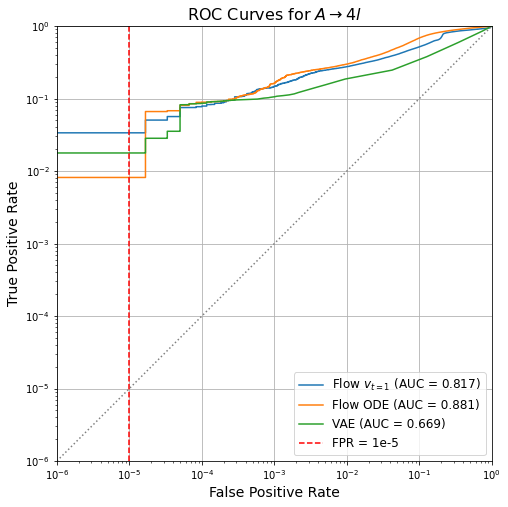

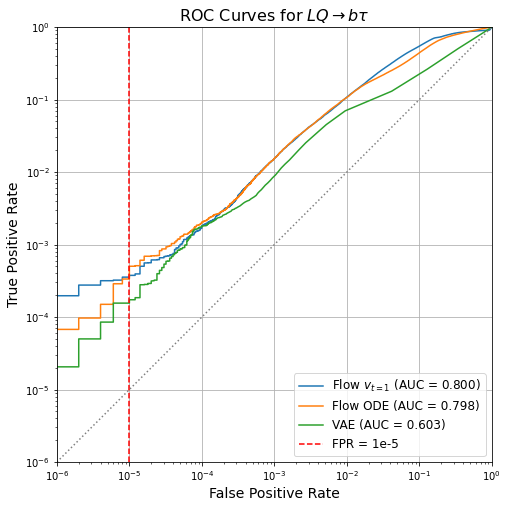

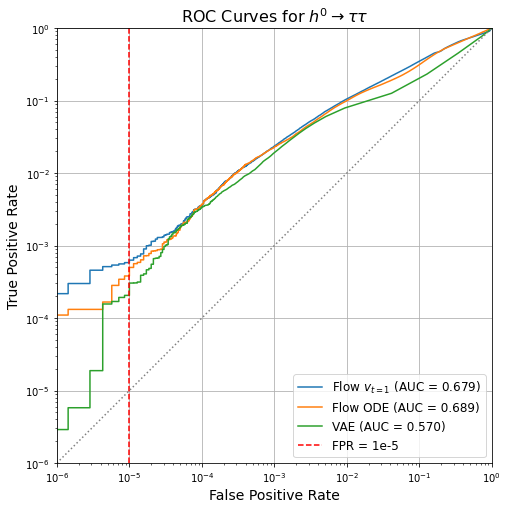

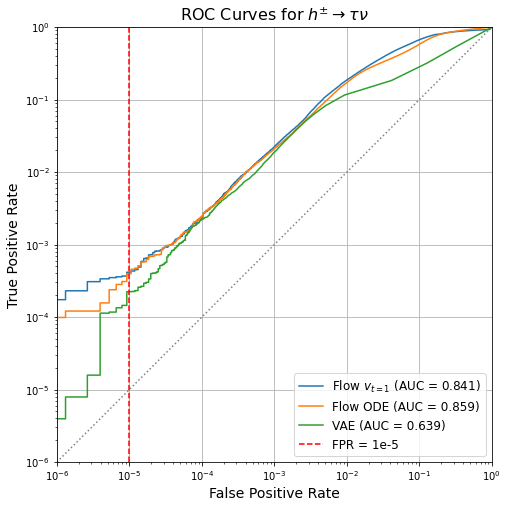

In [14]:
# Define dataset names and corresponding results prefixes/labels
dataset_info = [
    {"name": r"$A \rightarrow 4l$", "prefix": "Flow Matching ", "labels": dataset.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "vae_key": "VAE",  "old_vae_key": "VAE", "new_vae_key": "VAE NEW"},
    {"name": r"$LQ \rightarrow b \tau$", "prefix": "Flow Matching2 ", "labels": dataset2.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "vae_key": "VAE2", "old_vae_key": "VAE2 old", "new_vae_key": "VAE2 NEW"},
    {"name": r"$h^0 \rightarrow \tau \tau$", "prefix": "Flow Matching3 ", "labels": dataset3.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "vae_key": "VAE3", "old_vae_key": "VAE3 old", "new_vae_key": "VAE3 NEW"},
    {"name": r"$h^{\pm} \rightarrow \tau \nu$", "prefix": "Flow Matching4 ", "labels": dataset4.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "vae_key": "VAE4", "old_vae_key": "VAE4 old", "new_vae_key": "VAE4 NEW"},
]

for info in dataset_info:
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    dataset_name = info["name"]
    prefix = info["prefix"]
    labels = info["labels"]
    
    # Plot vt mode
    vt_key = prefix + info["suffix_vt"]
    if vt_key in results:
        result_vt = results[vt_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_vt["scores"],
            label= fr"Flow $v_{{t=1}}$ (AUC = {result_vt['auc']:.3f})", 
            ax=ax,
        )
    
    # Plot ode mode
    ode_key = prefix + info["suffix_ode"]
    if ode_key in results:
        result_ode = results[ode_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_ode["scores"],
            label=f"Flow ODE (AUC = {result_ode['auc']:.3f})",
            ax=ax,
        )
        
    # # Plot VAE results
    # vae_key = info["vae_key"]
    # if vae_key in results:
    #     result_vae = results[vae_key]
    #     RocCurveDisplay.from_predictions(
    #         labels,
    #         result_vae["scores"],
    #         name=f"VAE Katya(AUC = {result_vae['auc']:.3f})",
    #         ax=ax,
    #     )

    # old_vae_key = info["old_vae_key"]
    # if old_vae_key in results:
    #     result_vae = results[old_vae_key]
    #     RocCurveDisplay.from_predictions(
    #         labels,
    #         result_vae["scores"],
    #         name=f"VAE OLD(AUC = {result_vae['auc']:.3f})",
    #         ax=ax,
    #     )

    # Plot newly trained VAE results
    new_vae_key = info["new_vae_key"]
    if new_vae_key in results:
        result_vae_new = results[new_vae_key]
        RocCurveDisplay.from_predictions(
            labels,
            result_vae_new["scores"],
            label=f"VAE (AUC = {result_vae_new['auc']:.3f})",
            ax=ax,
        )
        
    # Add Isolation Forest for the first dataset for comparison
    if dataset_name == "A -> 4l" and "Isolation Forest" in results:
         result_iso = results["Isolation Forest"]
         RocCurveDisplay.from_predictions(
             labels,
             result_iso["scores"],
             name=f"Isolation Forest (AUC = {result_iso['auc']:.4f})",
             ax=ax,
         )

    plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
    # put dotted grey diagonal for baseline
    plt.plot([1e-6, 1], [1e-6, 1], color="grey", linestyle="dotted")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim([1e-6, 1])
    plt.ylim([1e-6, 1])
    plt.title(f"ROC Curves for {dataset_name}", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    #plt.savefig(f"./picts/roc_curves_{dataset_name.replace(' ', '_').lower()}_preproce.png", dpi=300)

    plt.show()
    # save the plot
    plt.close()


In [ ]:
results

{'Flow Matching vt': {'scores': array([ 0.42732424,  0.41461024,  0.42491654, ...,  6.394331  ,
          9.873918  , 29.36893   ], dtype=float32),
  'auc': 0.8170435367495101,
  'ap': 0.8310116530313362,
  'tpr@1e-5': 0.033715092283228214,
  'time': 1},
 'Flow Matching vt einsum': {'scores': array([1.8260603e-01, 1.7190166e-01, 1.8055406e-01, ..., 4.0887470e+01,
         9.7494240e+01, 8.6253406e+02], dtype=float32),
  'auc': 0.8170435412162685,
  'ap': 0.8310116681428383,
  'tpr@1e-5': 0.033715092283228214,
  'time': 1},
 'Flow Matching ode': {'scores': array([  58.145546,   58.779938,   61.753967, ...,   79.281586,
          148.66245 , 1484.5693  ], dtype=float32),
  'auc': 0.8809278331159511,
  'ap': 0.8823252859519755,
  'tpr@1e-5': 0.00816523432614483,
  'time': 1},
 'Flow Matching2 vt': {'scores': array([0.42732424, 0.41461024, 0.42491654, ..., 1.8835477 , 6.872104  ,
         0.62401545], dtype=float32),
  'auc': 0.7997886315777109,
  'ap': 0.7517868662870296,
  'tpr@1e-5': 0.

In [ ]:
# save the results dict except scores keys to a file which supports arrays
# STRUCTURE OF DICT IS LIKE
# {'Flow Matching vt': {'scores': array([ 0.42732424,  0.41461024,  0.42491654, ...,  6.394331  ,
#           9.873918  , 29.36893   ], dtype=float32),
#   'auc': 0.8170435367495101,
#   'ap': 0.8310116530313362,
#   'tpr@1e-5': 0.033715092283228214,
#   'time': 1},
#  'Flow Matching vt einsum': {'scores': array([1.8260603e-01, 1.7190166e-01, 1.8055406e-01, ..., 4.0887470e+01,
#          9.7494240e+01, 8.6253406e+02], dtype=float32),
#   'auc': 0.8170435412162685,
#   'ap': 0.8310116681428383,
#   'tpr@1e-5': 0.033715092283228214,
#   'time': 1},
import json
with open('results_preproce.json', 'w') as f:
    # Create a new dictionary without the 'scores' keys
    results_to_save = {
        key: {k: v for k, v in value.items() if k != 'scores'}
        for key, value in results.items()
    }
    json.dump(results_to_save, f, indent=4)

## 6. Score Distributions

9314893.0


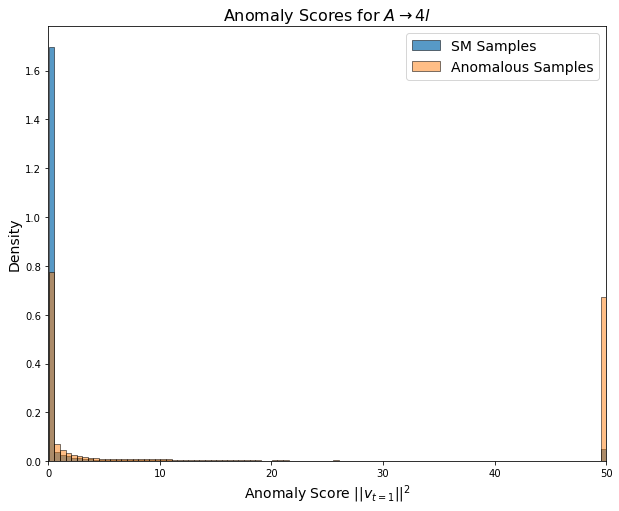

1307524.0


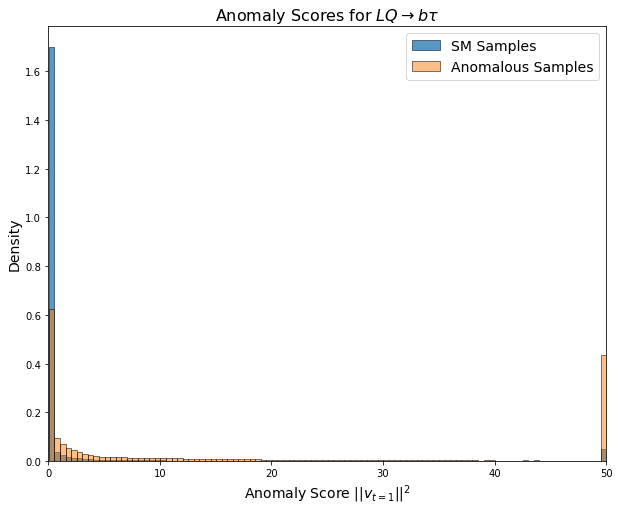

3817089.8


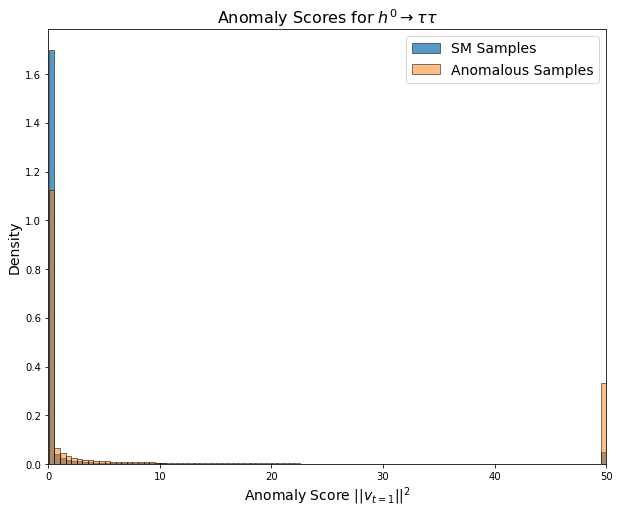

2943622.0


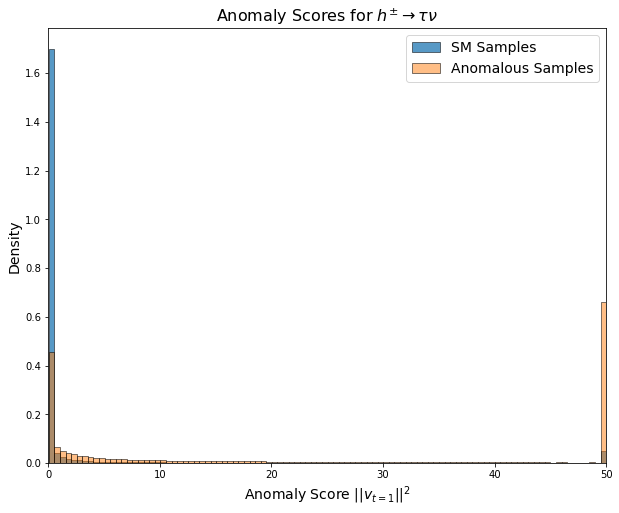

In [ ]:
# plot the scores of the models with different colors according to anomaly or not
# use only the flow matching vt einsum scores from the datasets
dataset_info = [
    {"name": r"$A \rightarrow 4l$", "prefix": "Flow Matching ", "labels": dataset.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "vae_key": "VAE",  "old_vae_key": "VAE", "new_vae_key": "VAE NEW"},
    {"name": r"$LQ \rightarrow b \tau$", "prefix": "Flow Matching2 ", "labels": dataset2.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "vae_key": "VAE2", "old_vae_key": "VAE2 old", "new_vae_key": "VAE2 NEW"},
    {"name": r"$h^0 \rightarrow \tau \tau$", "prefix": "Flow Matching3 ", "labels": dataset3.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "vae_key": "VAE3", "old_vae_key": "VAE3 old", "new_vae_key": "VAE3 NEW"},
    {"name": r"$h^{\pm} \rightarrow \tau \nu$", "prefix": "Flow Matching4 ", "labels": dataset4.test_labels, "suffix_vt": "vt einsum", "suffix_ode": "ode", "vae_key": "VAE4", "old_vae_key": "VAE4 old", "new_vae_key": "VAE4 NEW"},
]
saturation = 50  # saturation value for scores
for info in dataset_info:
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    dataset_name = info["name"]
    prefix = info["prefix"]
    labels = info["labels"]
    
    # Plot vt mode
    vt_key = prefix + info["suffix_vt"]
    if vt_key in results:
        result_vt = results[vt_key]
        print(result_vt['scores'].max())
        # take only scores under saturation value\
        normal_scores = result_vt["scores"][labels == 0]
        anomalous_scores = result_vt["scores"][labels == 1]
        
        normal_scores[normal_scores > saturation] = saturation
        anomalous_scores[anomalous_scores > saturation] = saturation
        
        sns.histplot(
            normal_scores,
            bins=100,
            label="SM Samples",
            stat="density",
            ax=ax,
        )
        sns.histplot(
            anomalous_scores,
            bins=100,
            label="Anomalous Samples",
            stat="density",
            ax=ax,
            alpha=0.5,
        )

   # plot options
    plt.xlim([0, saturation])
    # increase title font size
    plt.title(f"Anomaly Scores for {dataset_name}", fontsize=16)
    # increase font size
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.xlabel(r"Anomaly Score $||v_{{t=1}}||^2$", fontsize=14)
    plt.ylabel("Density", fontsize=14)

    plt.legend(fontsize=14)
    plt.savefig(f"./picts/anomaly_scores_{dataset_name.replace(' ', '_').lower()}_preproce.png", dpi=300)
    
    plt.show()
    # save the plot
    plt.close()

torch.Size([2, 5, 57])
torch.Size([2, 5, 57])


Text(0.5, 0.01, '○: Initial state   •: Intermediate states   ★: Final state')

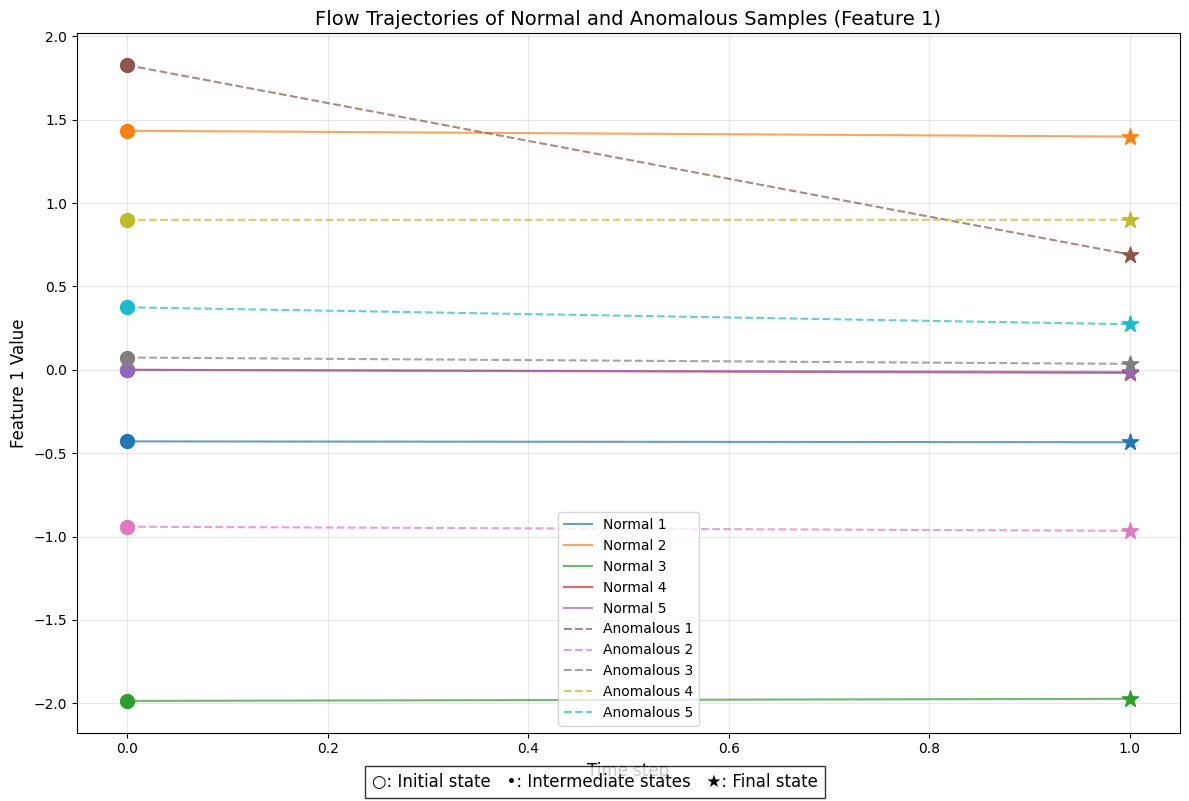

In [ ]:
# try and plot some trajectories for normal and anomalous samples
# get the indices of the normal and anomalous samples
normal_indices = np.where(dataset.test_labels == 0)[0]
anomalous_indices = np.where(dataset.test_labels == 1)[0]
# get the first 5 indices of each
normal_indices = normal_indices[:5]
anomalous_indices = anomalous_indices[:5]
# plot the trajectories for the normal samples
normal_trajectories = flow_matching.return_trajectories(
    X_test[normal_indices],
    mode="ODE",
    time_steps=2,
).swapaxes(0, 1)
anom_trajectories = flow_matching.return_trajectories(
    X_test[anomalous_indices],
    mode="ODE",
    time_steps=2,
).swapaxes(0, 1)

# Create a figure for the first feature trajectory visualization
plt.figure(figsize=(12, 8))

# Plot the trajectories
for i, trajectory in enumerate(normal_trajectories):
    plt.plot(trajectory[:, 4], label=f"Normal {i + 1}", color=f"C{i}", alpha=0.7)
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i}",
        s=150,
        zorder=10,
    )

for i, trajectory in enumerate(anom_trajectories):
    plt.plot(
        trajectory[:, 4],
        label=f"Anomalous {i + 1}",
        linestyle="--",
        color=f"C{i + 5}",
        alpha=0.7,
    )
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i + 5}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i + 5}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i + 5}",
        s=150,
        zorder=10,
    )

# Add visual enhancements
plt.title("Flow Trajectories of Normal and Anomalous Samples (Feature 1)", fontsize=14)
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Feature 1 Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()

# Add a text annotation explaining the markers
plt.figtext(
    0.5,
    0.01,
    "○: Initial state   •: Intermediate states   ★: Final state",
    ha="center",
    fontsize=12,
    bbox={"facecolor": "white", "alpha": 0.8, "pad": 5},
)

## 7. Results Summary

In [ ]:
# Create a summary table
print("==== Summary of Results ====")
print(f"{'Model':<20} {'AUC-ROC':<10} {'Avg Precision':<15} {'Training Time (s)':<15}")
print("-" * 60)
for name, result in results.items():
    print(
        f"{name:<20} {result['auc']:<10.4f} {result['ap']:<15.4f} {result['time']:<15.2f}"
    )

==== Summary of Results ====
Model                AUC-ROC    Avg Precision   Training Time (s)
------------------------------------------------------------
Isolation Forest     0.8711     0.8516          26.29          
Flow Matching vt     0.8663     0.8727          1.00           
Flow Matching vt einsum 0.8663     0.8727          1.00           
Flow Matching ode    0.8680     0.8726          1.00           
Flow Matching2 vt    0.7979     0.7636          1.00           
Flow Matching2 vt einsum 0.7979     0.7636          1.00           
Flow Matching2 ode   0.7945     0.7626          1.00           
Flow Matching3 vt    0.6611     0.6891          1.00           
Flow Matching3 vt einsum 0.6611     0.6891          1.00           
Flow Matching3 ode   0.6856     0.7038          1.00           
Flow Matching4 vt    0.8484     0.8366          1.00           
Flow Matching4 vt einsum 0.8484     0.8366          1.00           
Flow Matching4 ode   0.8547     0.8481          1.00         